In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
# from category_encoders import TargetEncoder
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve


/Users/dhanushlalitha/miniconda3/envs/is5126_project/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/dhanushlalitha/miniconda3/envs/is5126_project/lib/python3.11/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If 

In [2]:
# Load the data with outliers 
train_data = pd.read_csv("../data/nptrain.csv")
test_data = pd.read_csv("../data/nptest.csv")

In [3]:
train_data = train_data.drop(['issue_d', 'earliest_cr_line'], axis = 1)
test_data = test_data.drop(['issue_d', 'earliest_cr_line'], axis = 1)

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
train_data.tail()

,loan_amnt,term (months),int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,zip_code
228314,12050.0,36,10.99,394.45,B4,7.0,MORTGAGE,40000.0,Not Verified,Fully Paid,debt_consolidation,26.79,10.0,0.0,19039.0,76.5,25.0,Whole Funded,INDIVIDUAL,5.0,0.0,813
228315,28800.0,36,13.65,979.43,C1,3.0,RENT,108000.0,Source Verified,Fully Paid,debt_consolidation,21.92,14.0,0.0,30212.0,91.6,27.0,Whole Funded,INDIVIDUAL,0.0,0.0,70466
228316,13000.0,60,8.90,269.23,A5,10.0,MORTGAGE,46000.0,Verified,Fully Paid,debt_consolidation,1.54,9.0,0.0,1076.0,6.6,22.0,Whole Funded,INDIVIDUAL,2.0,0.0,22690
228317,10000.0,36,11.99,332.10,B3,10.0,OWN,70000.0,Not Verified,Charged Off,credit_card,14.71,15.0,0.0,8143.0,50.3,24.0,Whole Funded,INDIVIDUAL,0.0,0.0,30723
228318,6400.0,36,12.99,215.62,B5,4.0,MORTGAGE,55000.0,Source Verified,Fully Paid,debt_consolidation,31.86,19.0,0.0,19322.0,51.4,21.0,Fractional Funded,INDIVIDUAL,1.0,0.0,29597


In [6]:
len(test_data.columns), len(train_data.columns)

(22, 22)

In [7]:
train_data.shape, test_data.shape

((228319, 22), (112456, 22))

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228319 entries, 0 to 228318
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             228319 non-null  float64
 1   term (months)         228319 non-null  int64  
 2   int_rate              228319 non-null  float64
 3   installment           228319 non-null  float64
 4   sub_grade             228319 non-null  object 
 5   emp_length            228319 non-null  float64
 6   home_ownership        228319 non-null  object 
 7   annual_inc            228319 non-null  float64
 8   verification_status   228319 non-null  object 
 9   loan_status           228319 non-null  object 
 10  purpose               228319 non-null  object 
 11  dti                   228319 non-null  float64
 12  open_acc              228319 non-null  float64
 13  pub_rec               228319 non-null  float64
 14  revol_bal             228319 non-null  float64
 15  

In [9]:
target_column = 'loan_status'  # Replace with your actual target variable name

class_mapping = {'Fully Paid': 0, 'Charged Off': 1}  # Should we default

# Apply binary encoding to the target variable in the training DataFrame
train_data['Label'] = train_data[target_column].map(class_mapping)
test_data['Label'] = test_data[target_column].map(class_mapping)

In [10]:
print(train_data.shape)
train_data['Label'].value_counts(normalize=True) * 100


(228319, 23)


Label
0    80.250877
1    19.749123
Name: proportion, dtype: float64

In [11]:
print(test_data.shape)
test_data['Label'].value_counts(normalize=True) * 100

(112456, 23)


Label
0    80.279398
1    19.720602
Name: proportion, dtype: float64

 Leaving 'term (months)' as a number 

In [12]:
train_data = train_data.drop('loan_status', axis = 1)
test_data = test_data.drop('loan_status', axis = 1)

In [13]:
categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns

['sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'initial_list_status',
 'application_type']

In [14]:
for column in categorical_columns:
    unique_values = train_data[column].nunique()
    print(f"Column '{column}' has {unique_values} unique values.")

Column 'sub_grade' has 35 unique values.
Column 'home_ownership' has 4 unique values.
Column 'verification_status' has 3 unique values.
Column 'purpose' has 13 unique values.
Column 'initial_list_status' has 2 unique values.
Column 'application_type' has 3 unique values.


TODO : since home_ownership, verification_status, purpose and application_type have less than neary 10 categories we will use one hot encodign on them
target encoding for sub_grade and addr_state


In [15]:
cat_columns_ohe = ['home_ownership', 'verification_status', 'application_type', 'zip_code', 'sub_grade', 'purpose', 'initial_list_status']

# cat_columns_ohe = ['home_ownership', 'verification_status', 'application_type']
# cat_target_encoding = ['addr_state', 'sub_grade', 'purpose']



In [16]:
train_data.head()

,loan_amnt,term (months),int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,zip_code,Label
0,7000.0,36,8.99,222.57,B1,10.0,RENT,154000.0,Source Verified,credit_card,23.88,16.0,0.0,91725.0,62.2,48.0,Whole Funded,INDIVIDUAL,2.0,0.0,5113,0
1,2000.0,36,11.53,65.99,B5,3.0,RENT,41600.0,Not Verified,debt_consolidation,26.49,11.0,0.0,3541.0,20.1,16.0,Whole Funded,INDIVIDUAL,0.0,0.0,22690,0
2,24000.0,60,12.39,538.61,C1,10.0,MORTGAGE,120000.0,Source Verified,debt_consolidation,19.01,13.0,0.0,38065.0,79.0,34.0,Whole Funded,INDIVIDUAL,1.0,0.0,48052,0
3,15575.0,60,17.57,391.87,D2,5.0,MORTGAGE,62000.0,Source Verified,debt_consolidation,26.06,9.0,0.0,15089.0,74.7,23.0,Whole Funded,INDIVIDUAL,5.0,0.0,48052,1
4,12000.0,36,12.69,402.54,C2,1.0,RENT,36000.0,Source Verified,debt_consolidation,34.67,18.0,0.0,5681.0,38.6,28.0,Fractional Funded,INDIVIDUAL,0.0,0.0,86630,1


In [17]:
# encoder = TargetEncoder(cols=cat_target_encoding)

# encoder.fit(train_data[cat_target_encoding], train_data['Label'])


In [18]:
# X_train_encoded = encoder.transform(train_data[cat_target_encoding])
# X_test_encoded = encoder.transform(test_data[cat_target_encoding])

# # Replace original categorical columns with encoded columns in X_train and X_test
# X_train_encoded.columns = [f"{col}_encoded" for col in cat_target_encoding]
# X_test_encoded.columns = [f"{col}_encoded" for col in cat_target_encoding]

# # Drop original categorical columns from X_train and X_test
# train_data.drop(columns=cat_target_encoding, inplace=True)
# test_data.drop(columns=cat_target_encoding, inplace=True)

# # Concatenate encoded columns with remaining features
# train_data = pd.concat([train_data, X_train_encoded], axis=1)
# test_data = pd.concat([test_data, X_test_encoded], axis=1)

In [19]:
combined_df = pd.concat([train_data, test_data], axis=0)
combined_df.reset_index(drop=True, inplace=True)

custom_prefixes = {col: col + "_" for col in cat_columns_ohe}

encoded_combined_df = pd.get_dummies(combined_df, columns=cat_columns_ohe, drop_first=True, prefix=custom_prefixes)

encoded_combined_df.reset_index(drop=True, inplace=True)


In [20]:
train_data = encoded_combined_df.iloc[:len(train_data)]
train_data.reset_index(drop=True, inplace=True)
test_data = encoded_combined_df.iloc[len(train_data):]
test_data.reset_index(drop=True, inplace=True)


In [21]:
train_data.head()

,loan_amnt,term (months),int_rate,installment,emp_length,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,Label,home_ownership__OTHER,home_ownership__OWN,home_ownership__RENT,verification_status__Source Verified,verification_status__Verified,application_type__INDIVIDUAL,application_type__JOINT,zip_code__5113,zip_code__11650,zip_code__22690,zip_code__29597,zip_code__30723,zip_code__48052,zip_code__70466,zip_code__86630,zip_code__93700,sub_grade__A2,sub_grade__A3,sub_grade__A4,sub_grade__A5,sub_grade__B1,sub_grade__B2,sub_grade__B3,sub_grade__B4,sub_grade__B5,sub_grade__C1,sub_grade__C2,sub_grade__C3,sub_grade__C4,sub_grade__C5,sub_grade__D1,sub_grade__D2,sub_grade__D3,sub_grade__D4,sub_grade__D5,sub_grade__E1,sub_grade__E2,sub_grade__E3,sub_grade__E4,sub_grade__E5,sub_grade__F1,sub_grade__F2,sub_grade__F3,sub_grade__F4,sub_grade__F5,sub_grade__G1,sub_grade__G2,sub_grade__G3,sub_grade__G4,sub_grade__G5,purpose__credit_card,purpose__debt_consolidation,purpose__educational,purpose__home_improvement,purpose__house,purpose__major_purchase,purpose__medical,purpose__moving,purpose__other,purpose__renewable_energy,purpose__small_business,purpose__vacation,purpose__wedding,initial_list_status__Whole Funded
0,7000.0,36,8.99,222.57,10.0,154000.0,23.88,16.0,0.0,91725.0,62.2,48.0,2.0,0.0,0,False,False,True,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
1,2000.0,36,11.53,65.99,3.0,41600.0,26.49,11.0,0.0,3541.0,20.1,16.0,0.0,0.0,0,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True
2,24000.0,60,12.39,538.61,10.0,120000.0,19.01,13.0,0.0,38065.0,79.0,34.0,1.0,0.0,0,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True
3,15575.0,60,17.57,391.87,5.0,62000.0,26.06,9.0,0.0,15089.0,74.7,23.0,5.0,0.0,1,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True
4,12000.0,36,12.69,402.54,1.0,36000.0,34.67,18.0,0.0,5681.0,38.6,28.0,0.0,0.0,1,False,False,True,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False


In [22]:
numerical_columns = train_data.select_dtypes(include=['number']).columns.tolist()
# numerical_columns = [col for col in numerical_columns if col not in ['Label', 'addr_state_encoded', 'sub_grade_encoded', 'purpose_encoded']]
numerical_columns = [col for col in numerical_columns if col not in ['Label']]
numerical_columns

['loan_amnt',
 'term (months)',
 'int_rate',
 'installment',
 'emp_length',
 'annual_inc',
 'dti',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'mort_acc',
 'pub_rec_bankruptcies']

In [23]:
train_numerical_data = train_data[numerical_columns]
test_numerical_data = test_data[numerical_columns]

train_data = train_data.drop(columns=numerical_columns)
test_data = test_data.drop(columns=numerical_columns)

scaler = RobustScaler()
scaled_train_data = scaler.fit_transform(train_numerical_data)
scaled_test_data = scaler.transform(test_numerical_data)
scaled_train_df = pd.DataFrame(scaled_train_data, columns=numerical_columns)
scaled_test_df = pd.DataFrame(scaled_test_data, columns=numerical_columns)
robust_train_data = pd.concat([train_data, scaled_train_df], axis=1)
robust_test_data = pd.concat([test_data, scaled_test_df], axis=1)

 
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(train_numerical_data)
scaled_test_data = scaler.transform(test_numerical_data)
scaled_train_df = pd.DataFrame(scaled_train_data, columns=numerical_columns)
scaled_test_df = pd.DataFrame(scaled_test_data, columns=numerical_columns)
standard_train_data = pd.concat([train_data, scaled_train_df], axis=1)
standard_test_data = pd.concat([test_data, scaled_test_df], axis=1)


scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_numerical_data)
scaled_test_data = scaler.transform(test_numerical_data)
scaled_train_df = pd.DataFrame(scaled_train_data, columns=numerical_columns)
scaled_test_df = pd.DataFrame(scaled_test_data, columns=numerical_columns)
minmax_train_data = pd.concat([train_data, scaled_train_df], axis=1)
minmax_test_data = pd.concat([test_data, scaled_test_df], axis=1)

In [24]:
robust_train_data.head()



,Label,home_ownership__OTHER,home_ownership__OWN,home_ownership__RENT,verification_status__Source Verified,verification_status__Verified,application_type__INDIVIDUAL,application_type__JOINT,zip_code__5113,zip_code__11650,zip_code__22690,zip_code__29597,zip_code__30723,zip_code__48052,zip_code__70466,zip_code__86630,zip_code__93700,sub_grade__A2,sub_grade__A3,sub_grade__A4,sub_grade__A5,sub_grade__B1,sub_grade__B2,sub_grade__B3,sub_grade__B4,sub_grade__B5,sub_grade__C1,sub_grade__C2,sub_grade__C3,sub_grade__C4,sub_grade__C5,sub_grade__D1,sub_grade__D2,sub_grade__D3,sub_grade__D4,sub_grade__D5,sub_grade__E1,sub_grade__E2,sub_grade__E3,sub_grade__E4,sub_grade__E5,sub_grade__F1,sub_grade__F2,sub_grade__F3,sub_grade__F4,sub_grade__F5,sub_grade__G1,sub_grade__G2,sub_grade__G3,sub_grade__G4,sub_grade__G5,purpose__credit_card,purpose__debt_consolidation,purpose__educational,purpose__home_improvement,purpose__house,purpose__major_purchase,purpose__medical,purpose__moving,purpose__other,purpose__renewable_energy,purpose__small_business,purpose__vacation,purpose__wedding,initial_list_status__Whole Funded,loan_amnt,term (months),int_rate,installment,emp_length,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
0,0,False,False,True,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,-0.454167,0.0,-0.736755,-0.515645,0.571429,2.069767,0.563929,0.833333,0.0,5.846591,0.191136,1.5000,0.333333,0.0
1,0,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,-0.870833,0.0,-0.316225,-1.000976,-0.428571,-0.544186,0.784928,0.000000,0.0,-0.577069,-0.975069,-0.5000,-0.333333,0.0
2,0,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,0.962500,24.0,-0.173841,0.463944,0.571429,1.279070,0.151566,0.333333,0.0,1.937791,0.656510,0.6250,0.000000,0.0
3,1,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,0.260417,24.0,0.683775,0.009113,-0.142857,-0.069767,0.748518,-0.333333,0.0,0.264132,0.537396,-0.0625,1.333333,0.0
4,1,False,False,True,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,-0.037500,0.0,-0.124172,0.042185,-0.714286,-0.674419,1.477561,1.166667,0.0,-0.421183,-0.462604,0.2500,-0.333333,0.0


In [25]:
robust_train_data = robust_train_data[robust_train_data['dti'] >= 0]
standard_train_data = standard_train_data[standard_train_data['dti'] >= 0]
minmax_train_data = minmax_train_data[minmax_train_data['dti'] >= 0]


In [26]:
# train_data = train_data.drop('issue_d', axis = 1)
# test_data = test_data.drop('issue_d', axis = 1)

In [27]:
boolean_columns = train_data.select_dtypes(include=[bool]).columns

robust_train_data[boolean_columns] = robust_train_data[boolean_columns].astype(int)
robust_test_data[boolean_columns] = robust_test_data[boolean_columns].astype(int)

standard_train_data[boolean_columns] = standard_train_data[boolean_columns].astype(int)
standard_test_data[boolean_columns] = standard_test_data[boolean_columns].astype(int)

minmax_train_data[boolean_columns] = minmax_train_data[boolean_columns].astype(int)
minmax_test_data[boolean_columns] = minmax_test_data[boolean_columns].astype(int)





In [28]:
robust_train_data.head()



,Label,home_ownership__OTHER,home_ownership__OWN,home_ownership__RENT,verification_status__Source Verified,verification_status__Verified,application_type__INDIVIDUAL,application_type__JOINT,zip_code__5113,zip_code__11650,zip_code__22690,zip_code__29597,zip_code__30723,zip_code__48052,zip_code__70466,zip_code__86630,zip_code__93700,sub_grade__A2,sub_grade__A3,sub_grade__A4,sub_grade__A5,sub_grade__B1,sub_grade__B2,sub_grade__B3,sub_grade__B4,sub_grade__B5,sub_grade__C1,sub_grade__C2,sub_grade__C3,sub_grade__C4,sub_grade__C5,sub_grade__D1,sub_grade__D2,sub_grade__D3,sub_grade__D4,sub_grade__D5,sub_grade__E1,sub_grade__E2,sub_grade__E3,sub_grade__E4,sub_grade__E5,sub_grade__F1,sub_grade__F2,sub_grade__F3,sub_grade__F4,sub_grade__F5,sub_grade__G1,sub_grade__G2,sub_grade__G3,sub_grade__G4,sub_grade__G5,purpose__credit_card,purpose__debt_consolidation,purpose__educational,purpose__home_improvement,purpose__house,purpose__major_purchase,purpose__medical,purpose__moving,purpose__other,purpose__renewable_energy,purpose__small_business,purpose__vacation,purpose__wedding,initial_list_status__Whole Funded,loan_amnt,term (months),int_rate,installment,emp_length,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.454167,0.0,-0.736755,-0.515645,0.571429,2.069767,0.563929,0.833333,0.0,5.846591,0.191136,1.5000,0.333333,0.0
1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-0.870833,0.0,-0.316225,-1.000976,-0.428571,-0.544186,0.784928,0.000000,0.0,-0.577069,-0.975069,-0.5000,-0.333333,0.0
2,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0.962500,24.0,-0.173841,0.463944,0.571429,1.279070,0.151566,0.333333,0.0,1.937791,0.656510,0.6250,0.000000,0.0
3,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0.260417,24.0,0.683775,0.009113,-0.142857,-0.069767,0.748518,-0.333333,0.0,0.264132,0.537396,-0.0625,1.333333,0.0
4,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.037500,0.0,-0.124172,0.042185,-0.714286,-0.674419,1.477561,1.166667,0.0,-0.421183,-0.462604,0.2500,-0.333333,0.0


In [29]:
# numerical_cols = numerical_columns.append('Label')
numerical_cols = numerical_columns + ["Label"]
numerical_cols

['loan_amnt',
 'term (months)',
 'int_rate',
 'installment',
 'emp_length',
 'annual_inc',
 'dti',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'mort_acc',
 'pub_rec_bankruptcies',
 'Label']

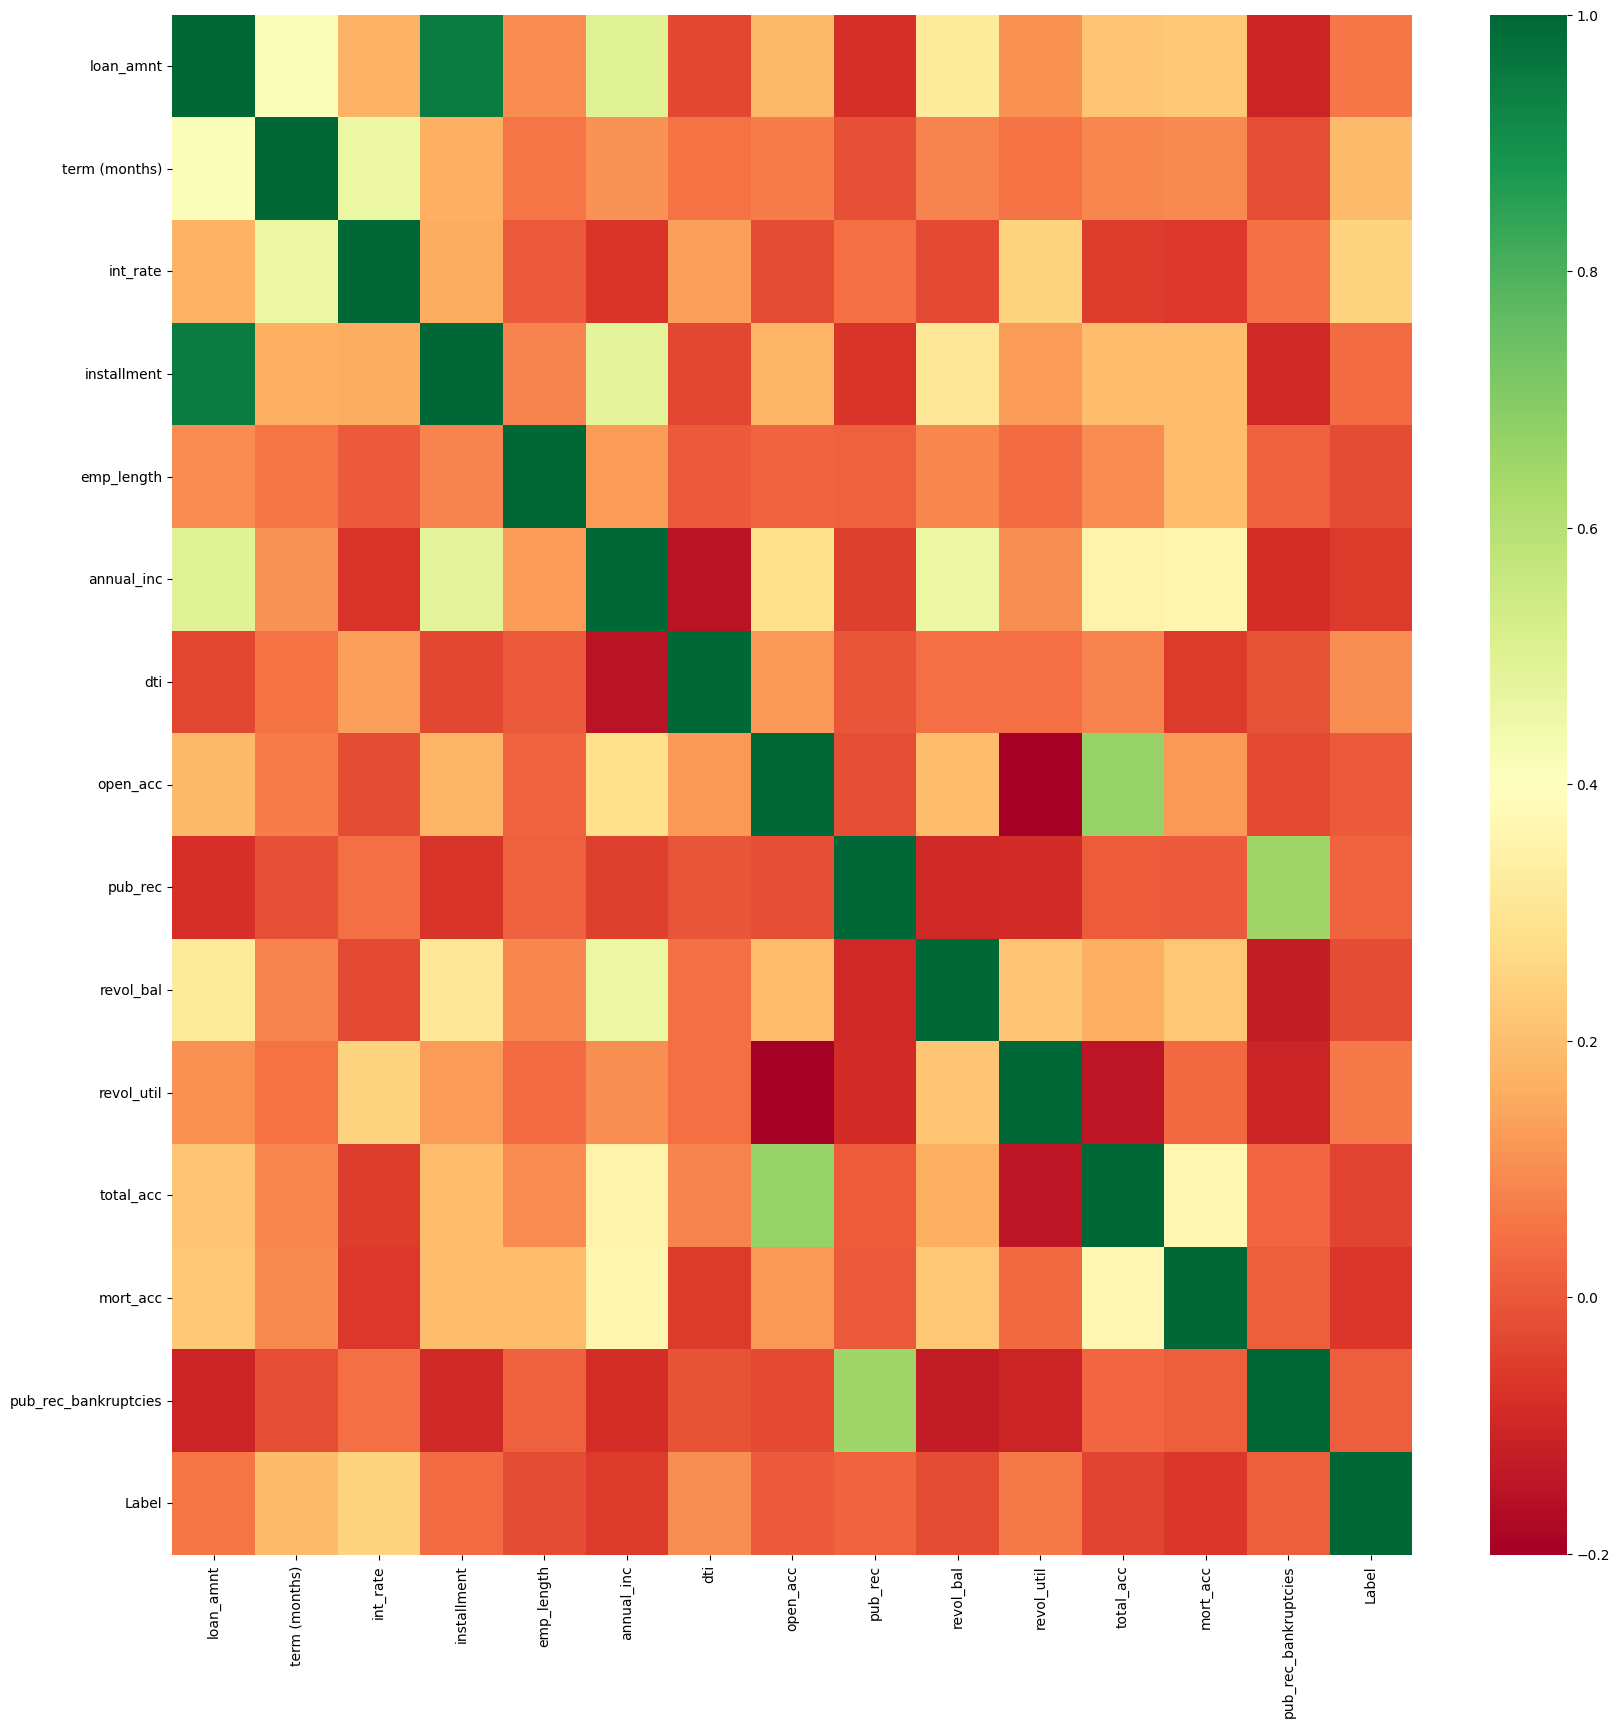

In [30]:
plt.figure(figsize = (20, 20))
sns.heatmap(robust_train_data[numerical_cols].corr(), cmap="RdYlGn")
plt.show()

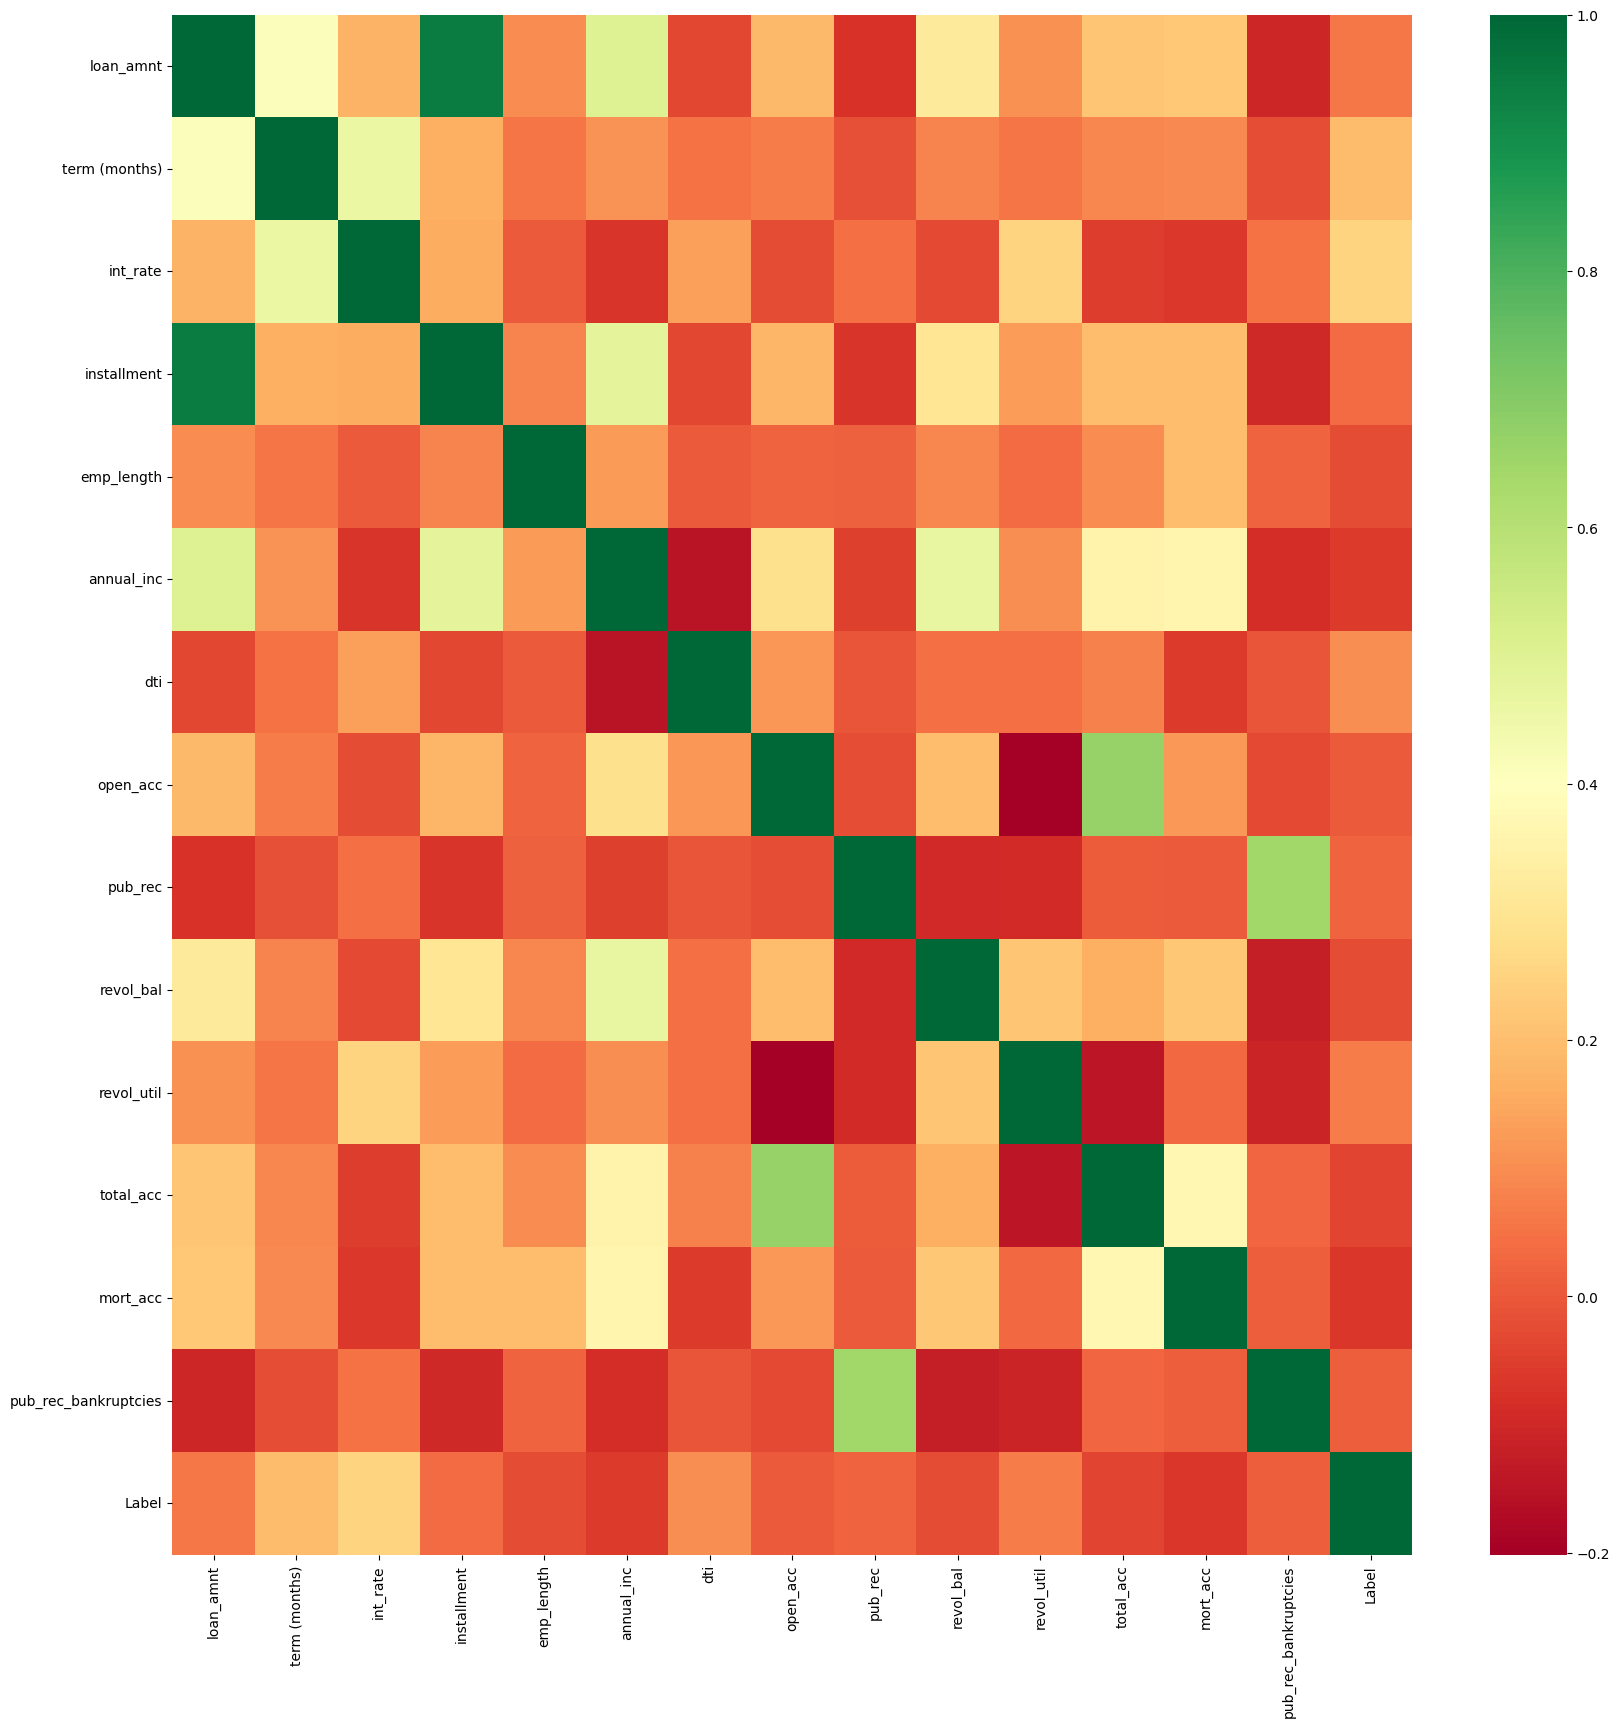

In [31]:
plt.figure(figsize = (20, 20))
sns.heatmap(standard_train_data[numerical_cols].corr(), cmap="RdYlGn")
plt.show()

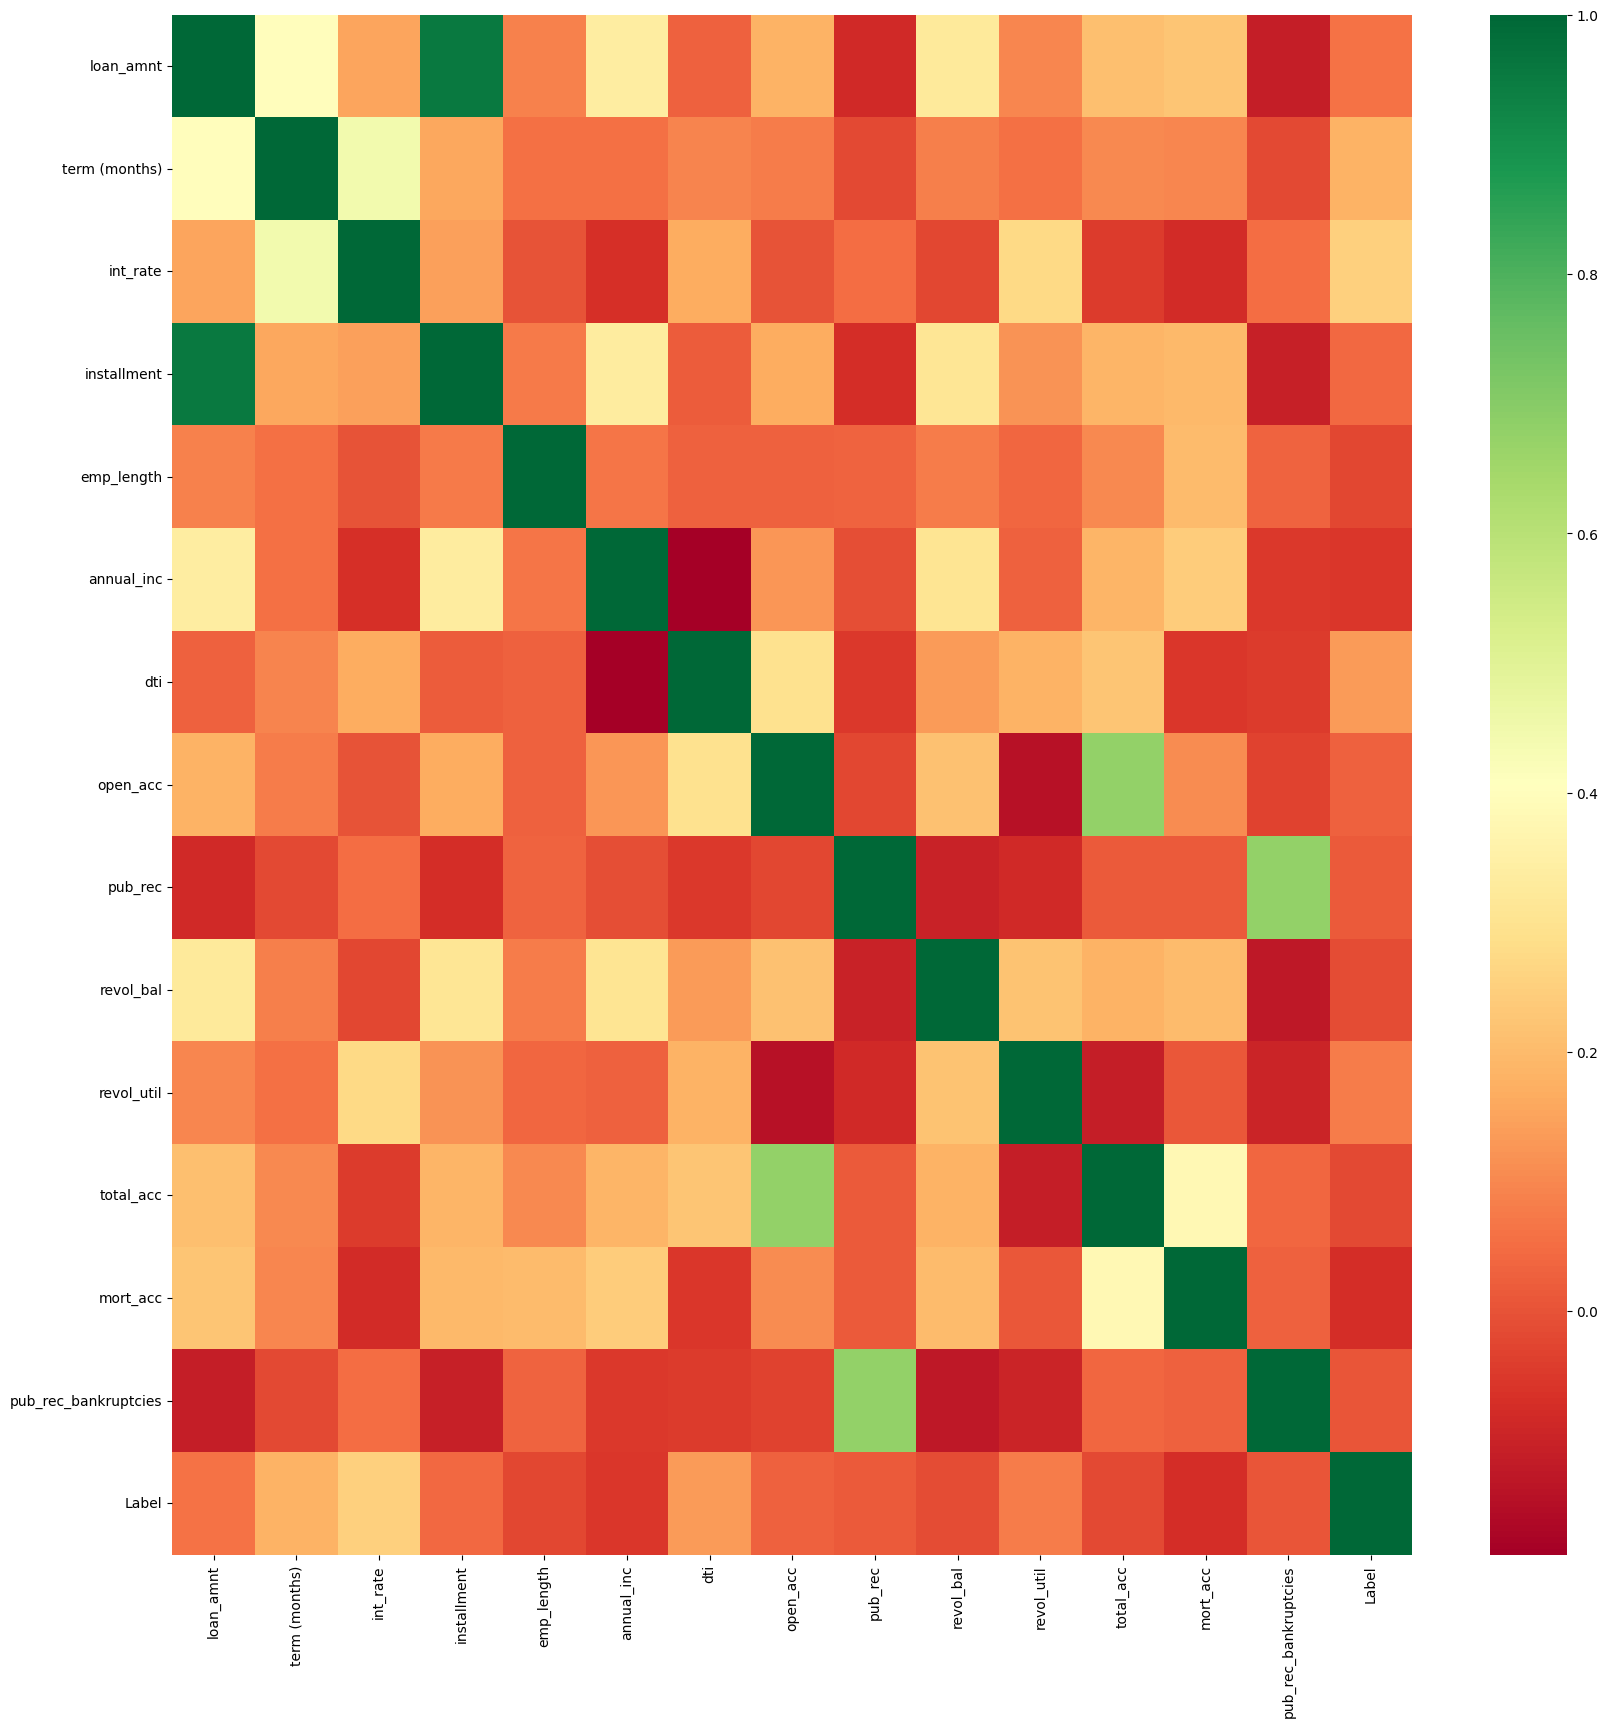

In [32]:
plt.figure(figsize = (20, 20))
sns.heatmap(minmax_train_data[numerical_cols].corr(), cmap="RdYlGn")
plt.show()

In [33]:
X_train_robust  = robust_train_data.drop("Label", axis = 1)
y_train_robust = robust_train_data["Label"]
X_test_robust = robust_test_data.drop("Label", axis = 1)
y_test_robust = robust_test_data["Label"]

X_train_standard = standard_train_data.drop("Label", axis=1)
y_train_standard = standard_train_data["Label"]
X_test_standard = standard_test_data.drop("Label", axis=1)
y_test_standard = standard_test_data["Label"]

X_train_minmax = minmax_train_data.drop("Label", axis=1)
y_train_minmax = minmax_train_data["Label"]
X_test_minmax = minmax_test_data.drop("Label", axis=1)
y_test_minmax = minmax_test_data["Label"]

In [34]:
X_train_robust.shape

(114212, 78)

In [35]:
# from sklearn.preprocessing import PowerTransformer

# # Select only the specified numerical columns
# # selected_numerical_columns = [col for col in numerical_columns if col not in ['Label', 'mort_acc', 'pub_rec']]
# selected_numerical_columns = [col for col in numerical_columns if col not in ['Label']]

# # Apply Box-Cox Transform after handling zero values
# train_data_transformed = X_train[selected_numerical_columns].apply(lambda x: x + 0.000001 if (x <= 0).any() else x)
# pt = PowerTransformer(method='box-cox')
# train_data_transformed[selected_numerical_columns] = pt.fit_transform(train_data_transformed)

# # Replace original numerical columns in X_train with their normalized versions
# X_train[selected_numerical_columns] = train_data_transformed[selected_numerical_columns]


In [36]:
# pd.DataFrame({'cols':selected_numerical_columns,'box_cox_lambdas':pt.lambdas_})

In [37]:
# X_train.columns[X_train.isna().any()].tolist()

In [38]:
# X_test.shape,y_test.shape, X_train.shape, y_train.shape

In [39]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

The SGDClassifier estimator in scikit-learn implements linear classifiers (SVM, logistic regression, and others) with stochastic gradient descent (SGD) training. A particular linear classifier is chosen through the loss hyperparameter. Because we want to predict the probability of charge-off, we choose logistic regression (a probabilistic classifier) by setting loss = 'log'.

# Basic model with Preprocessed Data

In [40]:
basic_model_robust = SGDClassifier(loss='log_loss')


In [41]:
basic_model_robust.fit(X_train_robust, y_train_robust)

SGDClassifier(loss='log_loss')

In [42]:
y_train_pred_robust = basic_model_robust.predict(X_train_robust)
y_pred_robust = basic_model_robust.predict(X_test_robust)

y_probs_robust = basic_model_robust.predict_proba(X_test_robust)[:, 1]

In [43]:
print_score(y_train_robust, y_train_pred_robust, train=True)
print_score(y_test_robust, y_pred_robust, train=False)


Train Result:
Accuracy Score: 83.68%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.893163      0.659945   0.83676       0.776554       0.837050
recall         0.891701      0.663355   0.83676       0.777528       0.836760
f1-score       0.892431      0.661646   0.83676       0.777039       0.836903
support    86732.000000  27480.000000   0.83676  114212.000000  114212.000000
_______________________________________________
Confusion Matrix: 
 [[77339  9393]
 [ 9251 18229]]

Test Result:
Accuracy Score: 86.02%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.909097      0.651169  0.860159       0.780133       0.858232
recall         0.917556      0.626505  0.860159       0.772030       0.860159
f1-score       0.913307      0.638599  0.860159       0.77595

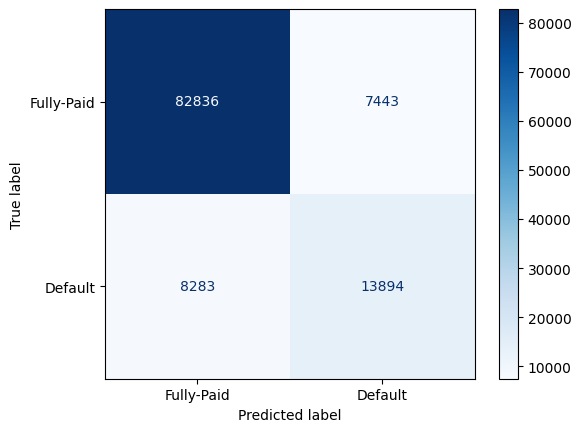

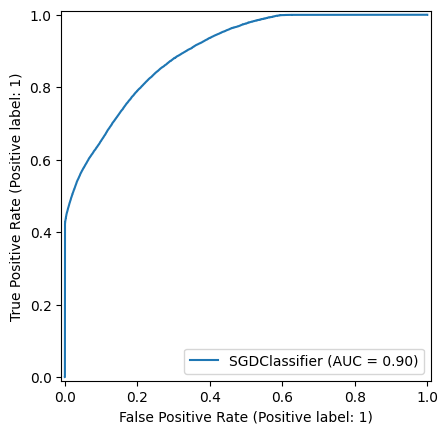

In [44]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    basic_model_robust, X_test_robust, y_test_robust, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully-Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(basic_model_robust, X_test_robust, y_test_robust)

In [45]:
basic_model_standard = SGDClassifier(loss='log_loss')

In [46]:
basic_model_standard.fit(X_train_standard, y_train_standard)

SGDClassifier(loss='log_loss')

In [47]:
y_train_pred_standard = basic_model_standard.predict(X_train_standard)
y_pred_standard = basic_model_standard.predict(X_test_standard)
y_probs_standard = basic_model_standard.predict_proba(X_test_standard)[:, 1]


In [48]:
print_score(y_train_standard, y_train_pred_standard, train=True)
print_score(y_test_standard, y_pred_standard, train=False)


Train Result:
Accuracy Score: 86.42%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.857185      0.911047  0.864183       0.884116       0.870253
recall         0.984740      0.487856  0.864183       0.736298       0.864183
f1-score       0.916546      0.635441  0.864183       0.775993       0.848342
support    82899.000000  26557.000000  0.864183  109456.000000  109456.000000
_______________________________________________
Confusion Matrix: 
 [[81634  1265]
 [13601 12956]]

Test Result:
Accuracy Score: 88.73%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.882344      0.933516  0.887334       0.907930       0.892436
recall         0.991925      0.461559  0.887334       0.726742       0.887334
f1-score       0.933931      0.617706  0.887334       0.77581

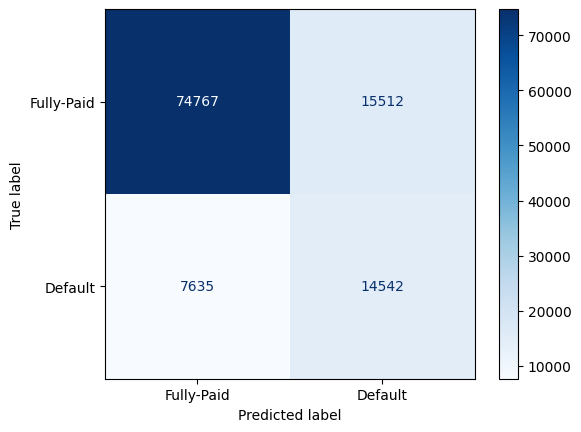

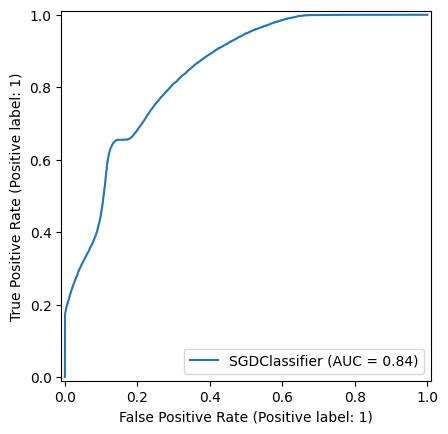

In [49]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    basic_model_standard, X_test_robust, y_test_robust, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully-Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(basic_model_standard, X_test_robust, y_test_robust)

In [50]:
basic_model_minmax = SGDClassifier(loss='log_loss')

In [51]:
basic_model_minmax.fit(X_train_minmax, y_train_minmax)

SGDClassifier(loss='log_loss')

In [52]:
y_train_pred_minmax = basic_model_minmax.predict(X_train_minmax)
y_pred_minmax = basic_model_minmax.predict(X_test_minmax)
y_probs_minmax = basic_model_minmax.predict_proba(X_test_minmax)[:, 1]

In [53]:
print_score(y_train_minmax, y_train_pred_minmax, train=True)
print_score(y_test_minmax, y_pred_minmax, train=False)


Train Result:
Accuracy Score: 88.79%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.877857      0.994574  0.887937       0.936215       0.900908
recall          0.999416      0.434943  0.887937       0.717179       0.887937
f1-score        0.934701      0.605215  0.887937       0.769958       0.869630
support    183228.000000  45091.000000  0.887937  228319.000000  228319.000000
_______________________________________________
Confusion Matrix: 
 [[183121    107]
 [ 25479  19612]]

Test Result:
Accuracy Score: 88.71%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.877199      0.993032  0.887103       0.935115       0.900042
recall         0.999258      0.430536  0.887103       0.714897       0.887103
f1-score       0.934258      0.600654  0.887103     

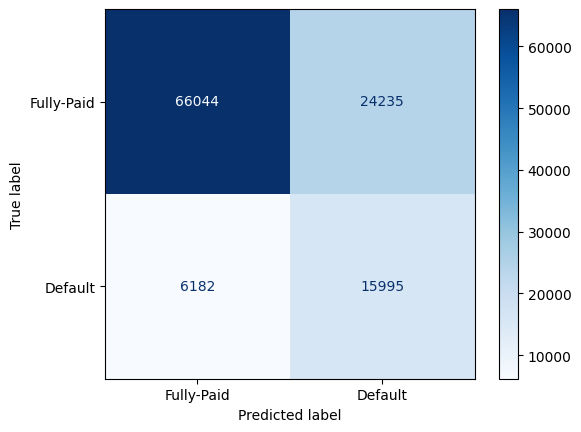

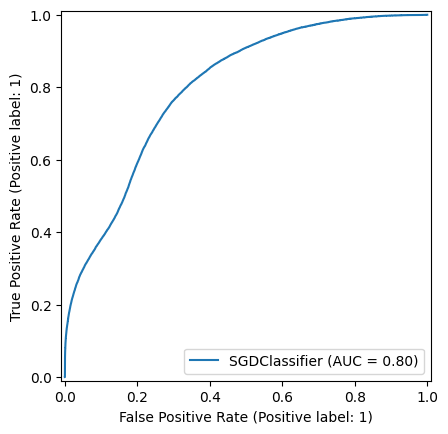

In [54]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    basic_model_minmax, X_test_robust, y_test_robust, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully-Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(basic_model_minmax, X_test_robust, y_test_robust)

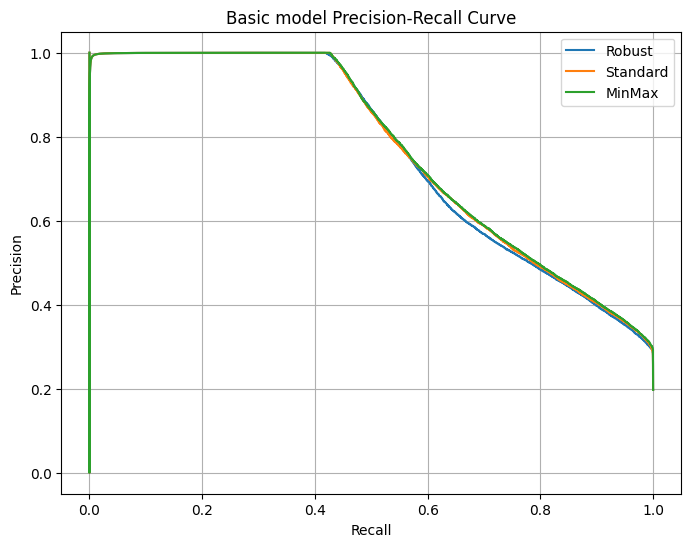

In [55]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for y_pred, y_true, label in zip([y_probs_robust, y_probs_standard, y_probs_minmax],[y_test_robust, y_test_standard, y_test_minmax], ['Robust', 'Standard', 'MinMax']):
    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    
    # Plot precision-recall curve
    plt.plot(recall, precision, label=label)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Basic model Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


# Model with Entire Data ( Tuning)

In [56]:
model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=1, warm_start=True, class_weight='balanced')

kf = StratifiedKFold(n_splits=5, shuffle=False)


In [57]:
param_grid_sgdlogreg = {
    'alpha': [10**-5, 10**-2, 10**1],
    'penalty': ['l1', 'l2']
}

In [58]:
grid_sgdlogreg_robust = GridSearchCV(estimator=model, 
                               param_grid=param_grid_sgdlogreg, 
                               scoring='f1_weighted',  # Change scoring metric to F1 score
                               n_jobs=-1, 
                               pre_dispatch='2*n_jobs', 
                               cv=kf, 
                               verbose=1, 
                               return_train_score=False)

grid_sgdlogreg_standard = GridSearchCV(estimator=model, 
                               param_grid=param_grid_sgdlogreg, 
                               scoring='f1_weighted',  # Change scoring metric to F1 score
                               n_jobs=-1, 
                               pre_dispatch='2*n_jobs', 
                               cv=kf, 
                               verbose=1, 
                               return_train_score=False)


grid_sgdlogreg_minmax = GridSearchCV(estimator=model, 
                               param_grid=param_grid_sgdlogreg, 
                               scoring='f1_weighted',  # Change scoring metric to F1 score
                               n_jobs=-1, 
                               pre_dispatch='2*n_jobs', 
                               cv=kf, 
                               verbose=1, 
                               return_train_score=False)

In [59]:
grid_sgdlogreg_robust.fit(X_train_robust, y_train_robust)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SGDClassifier(class_weight='balanced', loss='log_loss',
                                     random_state=1, warm_start=True),
             n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.01, 10], 'penalty': ['l1', 'l2']},
             scoring='f1_weighted', verbose=1)

In [60]:
grid_sgdlogreg_robust.best_score_

0.8108845986209345

In [61]:
grid_sgdlogreg_robust.best_params_

{'alpha': 0.01, 'penalty': 'l1'}

In [62]:
grid_sgdlogreg_standard.fit(X_train_standard, y_train_standard)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/dhanushlalitha/miniconda3/envs/is5126_project/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SGDClassifier(class_weight='balanced', loss='log_loss',
                                     random_state=1, warm_start=True),
             n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.01, 10], 'penalty': ['l1', 'l2']},
             scoring='f1_weighted', verbose=1)

In [63]:
grid_sgdlogreg_standard.best_score_

0.8166918124980602

In [64]:
grid_sgdlogreg_standard.best_params_

{'alpha': 1e-05, 'penalty': 'l1'}

In [65]:
grid_sgdlogreg_minmax.fit(X_train_minmax, y_train_minmax)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SGDClassifier(class_weight='balanced', loss='log_loss',
                                     random_state=1, warm_start=True),
             n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.01, 10], 'penalty': ['l1', 'l2']},
             scoring='f1_weighted', verbose=1)

In [66]:
grid_sgdlogreg_minmax.best_score_

0.828765000342546

In [67]:
grid_sgdlogreg_minmax.best_params_

{'alpha': 0.01, 'penalty': 'l1'}

In [68]:
y_train_pred_robust = grid_sgdlogreg_robust.predict(X_train_robust)
y_pred_robust = grid_sgdlogreg_robust.predict(X_test_robust)
y_probs_robust = grid_sgdlogreg_robust.predict_proba(X_test_robust)[:, 1]

In [69]:
print_score(y_train_robust, y_train_pred_robust, train=True)
print_score(y_test_robust, y_pred_robust, train=False)


Train Result:
Accuracy Score: 82.13%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.888426      0.622508  0.821271       0.755467       0.824444
recall         0.874464      0.653384  0.821271       0.763924       0.821271
f1-score       0.881389      0.637573  0.821271       0.759481       0.822726
support    86732.000000  27480.000000  0.821271  114212.000000  114212.000000
_______________________________________________
Confusion Matrix: 
 [[75844 10888]
 [ 9525 17955]]

Test Result:
Accuracy Score: 85.07%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.905157      0.623639  0.850662       0.764398       0.849640
recall         0.909248      0.612166  0.850662       0.760707       0.850662
f1-score       0.907198      0.617849  0.850662       0.76252

In [70]:
y_train_pred_standard = grid_sgdlogreg_standard.predict(X_train_standard)
y_pred_standard = grid_sgdlogreg_standard.predict(X_test_standard)
y_probs_standard = grid_sgdlogreg_standard.predict_proba(X_test_standard)[:, 1]

In [71]:
print_score(y_train_standard, y_train_pred_standard, train=True)
print_score(y_test_standard, y_pred_standard, train=False)

Train Result:
Accuracy Score: 78.80%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.929248      0.542050  0.788043       0.735649       0.835303
recall         0.779491      0.814738  0.788043       0.797114       0.788043
f1-score       0.847807      0.650991  0.788043       0.749399       0.800054
support    82899.000000  26557.000000  0.788043  109456.000000  109456.000000
_______________________________________________
Confusion Matrix: 
 [[64619 18280]
 [ 4920 21637]]

Test Result:
Accuracy Score: 80.20%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.939082      0.498715  0.801994       0.718898       0.852239
recall         0.805614      0.787257  0.801994       0.796435       0.801994
f1-score       0.867243      0.610615  0.801994       0.73892

In [72]:
y_train_pred_minmax = grid_sgdlogreg_minmax.predict(X_train_minmax)
y_pred_minmax = grid_sgdlogreg_minmax.predict(X_test_minmax)
y_probs_minmax = grid_sgdlogreg_minmax.predict_proba(X_test_minmax)[:, 1]

In [73]:
print_score(y_train_minmax, y_train_pred_minmax, train=True)
print_score(y_test_minmax, y_pred_minmax, train=False)

Train Result:
Accuracy Score: 82.54%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.913206      0.547676  0.825411       0.730441       0.841017
recall          0.864622      0.666075  0.825411       0.765349       0.825411
f1-score        0.888250      0.601101  0.825411       0.744676       0.831541
support    183228.000000  45091.000000  0.825411  228319.000000  228319.000000
_______________________________________________
Confusion Matrix: 
 [[158423  24805]
 [ 15057  30034]]

Test Result:
Accuracy Score: 82.31%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.912089      0.542272  0.823131       0.727181       0.839159
recall         0.862847      0.661451  0.823131       0.762149       0.823131
f1-score       0.886785      0.595962  0.823131     

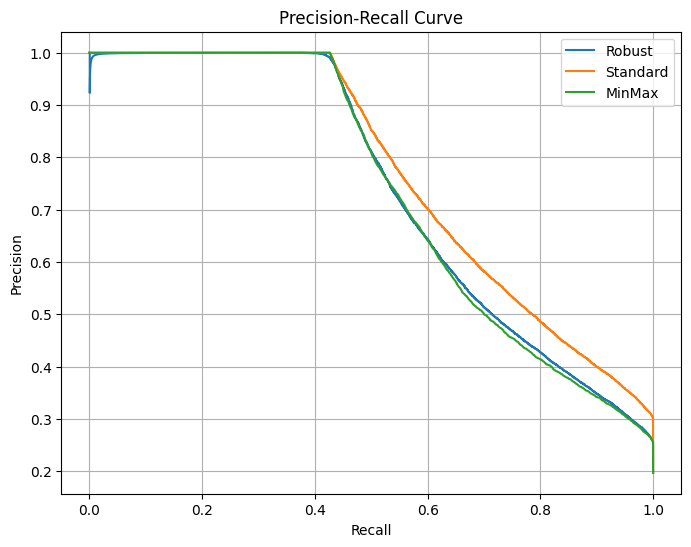

In [74]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for y_pred, y_true, label in zip([y_probs_robust, y_probs_standard, y_probs_minmax],[y_test_robust, y_test_standard, y_test_minmax], ['Robust', 'Standard', 'MinMax']):
    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    
    # Plot precision-recall curve
    plt.plot(recall, precision, label=label)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


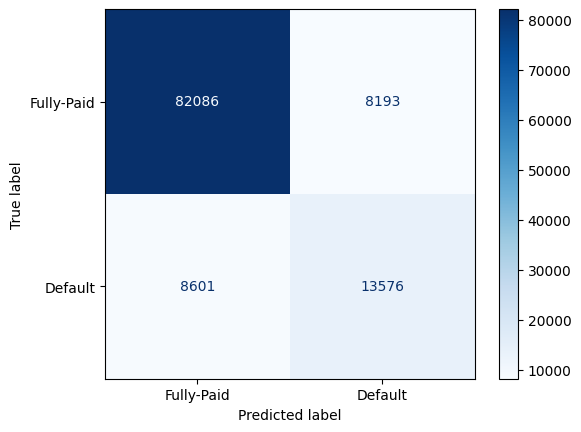

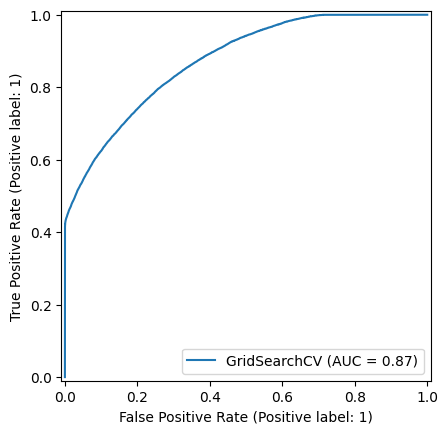

In [75]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    grid_sgdlogreg_robust, X_test_robust, y_test_robust, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully-Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(grid_sgdlogreg_robust, X_test_robust, y_test_robust)

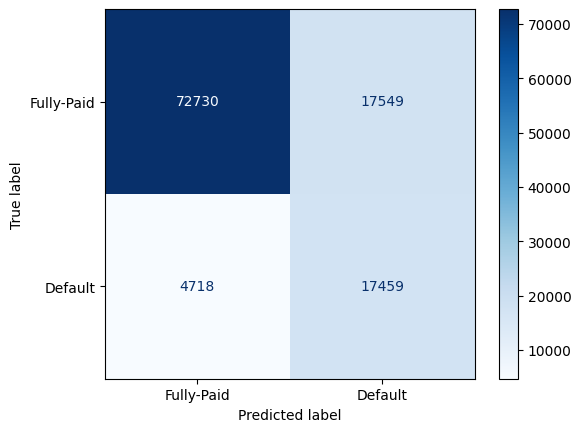

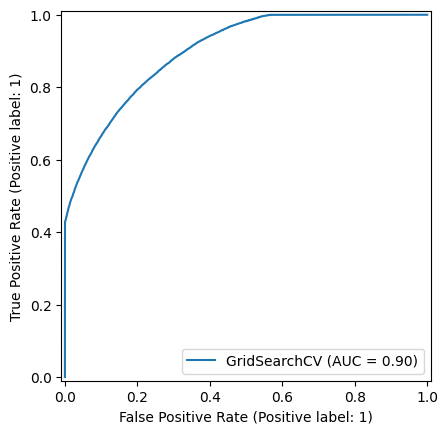

In [76]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    grid_sgdlogreg_standard, X_test_standard, y_test_standard, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully-Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(grid_sgdlogreg_standard, X_test_standard, y_test_robust)

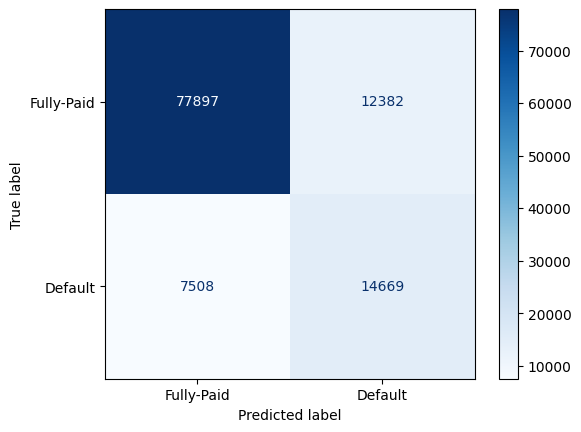

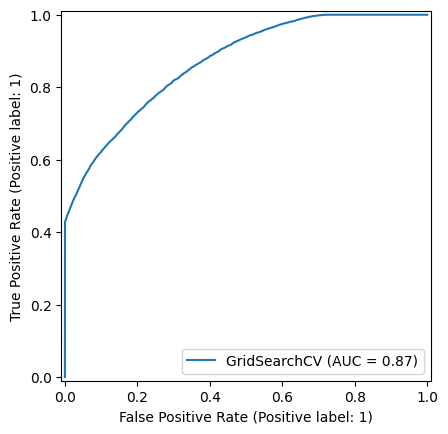

In [77]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    grid_sgdlogreg_minmax, X_test_minmax, y_test_minmax, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully-Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(grid_sgdlogreg_minmax, X_test_minmax, y_test_minmax)

## With undersampling

In [78]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler

In [79]:
rus = RandomUnderSampler(random_state=42)

In [80]:
X_under_robust, y_under_robust = rus.fit_resample(X_train_robust, y_train_robust)
X_under_minmax, y_under_minmax = rus.fit_resample(X_train_minmax, y_train_minmax)
X_under_standard, y_under_standard = rus.fit_resample(X_train_standard, y_train_standard)

In [81]:
print('Fully Paid:', y_under_robust.value_counts()[0], '/', round(y_under_robust.value_counts()[0]/len(y_under_robust) * 100,2), '% of the dataset')
print('Charged Off:', y_under_robust.value_counts()[1], '/',round(y_under_robust.value_counts()[1]/len(y_under_robust) * 100,2), '% of the dataset')




Fully Paid: 27480 / 50.0 % of the dataset
Charged Off: 27480 / 50.0 % of the dataset


In [82]:
param_grid_sgdlogreg = {
    'sgdclassifier__alpha': [0.00001, 0.001, 10],
    'sgdclassifier__penalty': ['l1', 'l2'],
}

In [83]:
pipeline = make_pipeline(RandomUnderSampler(random_state=42),
                       SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=1, warm_start=True, class_weight='balanced'))



In [84]:
grid_sgdlogreg_robust = GridSearchCV(estimator=pipeline, 
                               param_grid=param_grid_sgdlogreg, 
                               scoring='f1',  # Change scoring metric to F1 score
                               n_jobs=-1, 
                               pre_dispatch='2*n_jobs', 
                               cv=kf, 
                               verbose=1, 
                               return_train_score=True)

grid_sgdlogreg_standard = GridSearchCV(estimator=pipeline, 
                               param_grid=param_grid_sgdlogreg, 
                               scoring='f1',  # Change scoring metric to F1 score
                               n_jobs=-1, 
                               pre_dispatch='2*n_jobs', 
                               cv=kf, 
                               verbose=1, 
                               return_train_score=True)


grid_sgdlogreg_minmax = GridSearchCV(estimator=pipeline, 
                               param_grid=param_grid_sgdlogreg, 
                               scoring='f1',  # Change scoring metric to F1 score
                               n_jobs=-1, 
                               pre_dispatch='2*n_jobs', 
                               cv=kf, 
                               verbose=1, 
                               return_train_score=True)

In [85]:
grid_sgdlogreg_robust.fit(X_train_robust, y_train_robust)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/dhanushlalitha/miniconda3/envs/is5126_project/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('sgdclassifier',
                                        SGDClassifier(class_weight='balanced',
                                                      loss='log_loss',
                                                      random_state=1,
                                                      warm_start=True))]),
             n_jobs=-1,
             param_grid={'sgdclassifier__alpha': [1e-05, 0.001, 10],
                         'sgdclassifier__penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1', verbose=1)

In [86]:
grid_sgdlogreg_robust.best_score_

0.6578291120882593

In [87]:
grid_sgdlogreg_robust.best_params_

{'sgdclassifier__alpha': 0.001, 'sgdclassifier__penalty': 'l1'}

In [88]:
y_train_pred_robust = grid_sgdlogreg_robust.predict(X_train_robust)
y_pred_robust = grid_sgdlogreg_robust.predict(X_test_robust)
y_probs_robust = grid_sgdlogreg_robust.predict_proba(X_test_robust)[:, 1]

In [89]:
print_score(y_train_robust, y_train_pred_robust, train=True)
print_score(y_test_robust, y_pred_robust, train=False)


Train Result:
Accuracy Score: 79.36%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.926403      0.548722  0.793647       0.737563       0.835531
recall         0.791115      0.801638  0.793647       0.796376       0.793647
f1-score       0.853431      0.651495  0.793647       0.752463       0.804844
support    86732.000000  27480.000000  0.793647  114212.000000  114212.000000
_______________________________________________
Confusion Matrix: 
 [[68615 18117]
 [ 5451 22029]]

Test Result:
Accuracy Score: 83.39%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.926486      0.561358  0.833908       0.743922       0.854480
recall         0.861463      0.721739  0.833908       0.791601       0.833908
f1-score       0.892792      0.631525  0.833908       0.76215

In [90]:
grid_sgdlogreg_standard.fit(X_train_standard, y_train_standard)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('sgdclassifier',
                                        SGDClassifier(class_weight='balanced',
                                                      loss='log_loss',
                                                      random_state=1,
                                                      warm_start=True))]),
             n_jobs=-1,
             param_grid={'sgdclassifier__alpha': [1e-05, 0.001, 10],
                         'sgdclassifier__penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1', verbose=1)

In [91]:
grid_sgdlogreg_standard.best_score_

0.6591823580505634

In [92]:
grid_sgdlogreg_standard.best_params_

{'sgdclassifier__alpha': 0.001, 'sgdclassifier__penalty': 'l2'}

In [93]:
y_train_pred_standard = grid_sgdlogreg_standard.predict(X_train_standard)
y_pred_standard = grid_sgdlogreg_standard.predict(X_test_standard)
y_probs_standard = grid_sgdlogreg_standard.predict_proba(X_test_standard)[:, 1]

In [94]:
print_score(y_train_standard, y_train_pred_standard, train=True)
print_score(y_test_standard, y_pred_standard, train=False)

Train Result:
Accuracy Score: 80.01%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.923597      0.562490  0.800111       0.743044       0.835983
recall         0.802458      0.792785  0.800111       0.797622       0.800111
f1-score       0.858777      0.658071  0.800111       0.758424       0.810080
support    82899.000000  26557.000000  0.800111  109456.000000  109456.000000
_______________________________________________
Confusion Matrix: 
 [[66523 16376]
 [ 5503 21054]]

Test Result:
Accuracy Score: 83.67%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.926062      0.567941  0.836701       0.747002       0.855438
recall         0.865705      0.718627  0.836701       0.792166       0.836701
f1-score       0.894867      0.634460  0.836701       0.76466

In [95]:
grid_sgdlogreg_minmax.fit(X_train_minmax, y_train_minmax)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('sgdclassifier',
                                        SGDClassifier(class_weight='balanced',
                                                      loss='log_loss',
                                                      random_state=1,
                                                      warm_start=True))]),
             n_jobs=-1,
             param_grid={'sgdclassifier__alpha': [1e-05, 0.001, 10],
                         'sgdclassifier__penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1', verbose=1)

In [96]:
grid_sgdlogreg_minmax.best_score_

0.6200803483581965

In [97]:
grid_sgdlogreg_minmax.best_params_

{'sgdclassifier__alpha': 0.001, 'sgdclassifier__penalty': 'l1'}

In [98]:
y_train_pred_minmax = grid_sgdlogreg_minmax.predict(X_train_minmax)
y_pred_minmax = grid_sgdlogreg_minmax.predict(X_test_minmax)
y_probs_minmax = grid_sgdlogreg_minmax.predict_proba(X_test_minmax)[:, 1]

In [99]:
print_score(y_train_minmax, y_train_pred_minmax, train=True)
print_score(y_test_minmax, y_pred_minmax, train=False)

Train Result:
Accuracy Score: 81.25%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.937013      0.516825  0.812482       0.726919       0.854030
recall          0.821561      0.775587  0.812482       0.798574       0.812482
f1-score        0.875497      0.620302  0.812482       0.747900       0.825098
support    183228.000000  45091.000000  0.812482  228319.000000  228319.000000
_______________________________________________
Confusion Matrix: 
 [[150533  32695]
 [ 10119  34972]]

Test Result:
Accuracy Score: 80.98%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.934922      0.511831  0.809792       0.723377       0.851486
recall         0.820158      0.767597  0.809792       0.793877       0.809792
f1-score       0.873787      0.614150  0.809792     

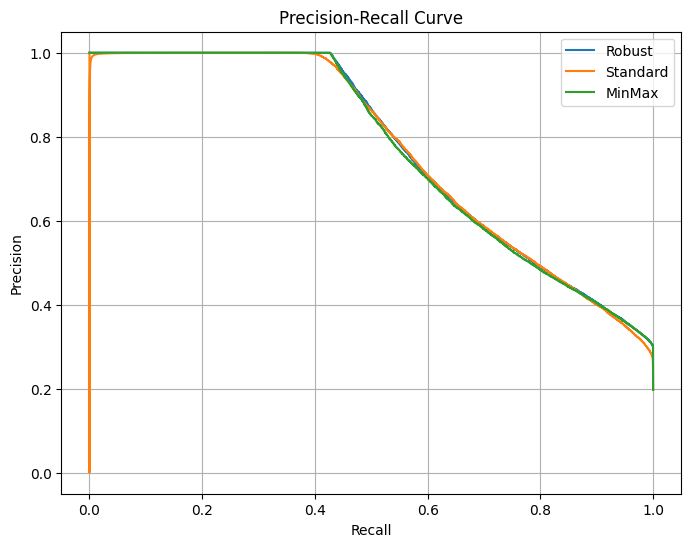

In [100]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for y_pred, y_true, label in zip([y_probs_robust, y_probs_standard, y_probs_minmax],[y_test_robust, y_test_standard, y_test_minmax], ['Robust', 'Standard', 'MinMax']):
    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    
    # Plot precision-recall curve
    plt.plot(recall, precision, label=label)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


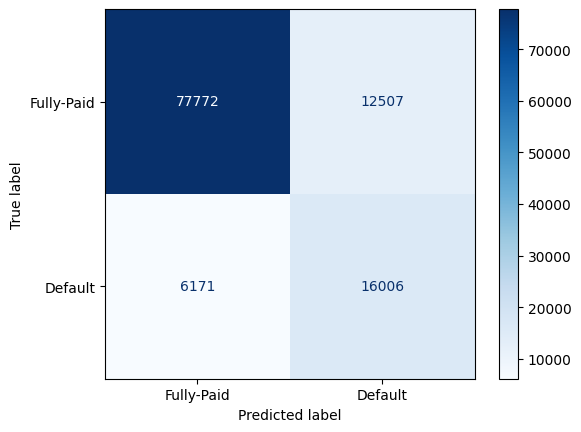

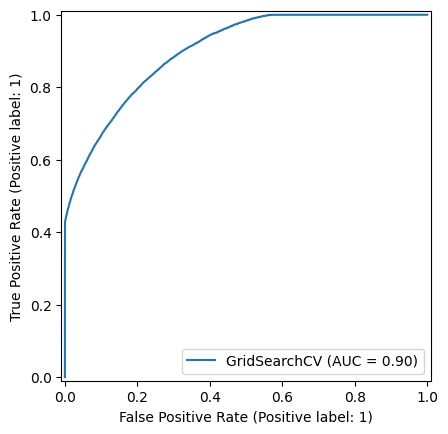

In [101]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    grid_sgdlogreg_robust, X_test_robust, y_test_robust, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully-Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(grid_sgdlogreg_robust, X_test_robust, y_test_robust)

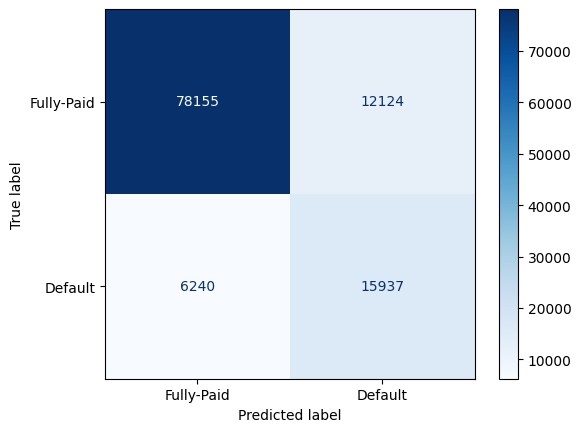

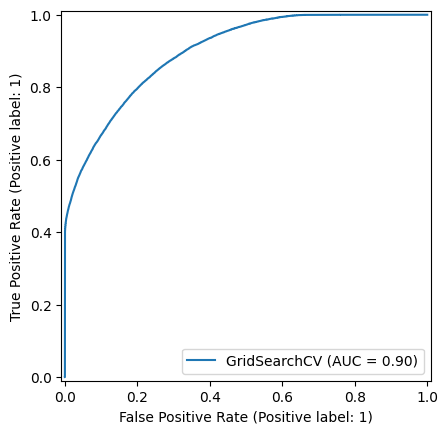

In [102]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    grid_sgdlogreg_standard, X_test_standard, y_test_standard, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully-Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(grid_sgdlogreg_standard, X_test_standard, y_test_robust)

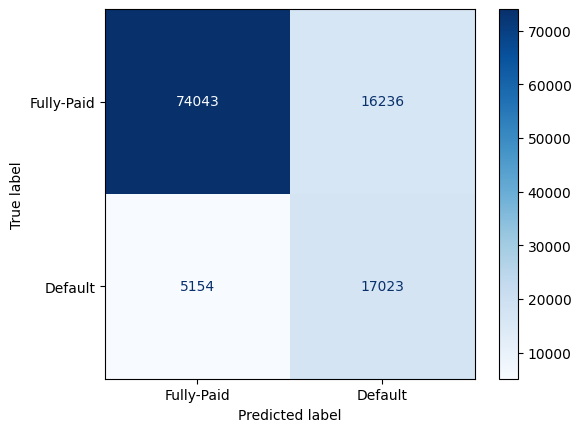

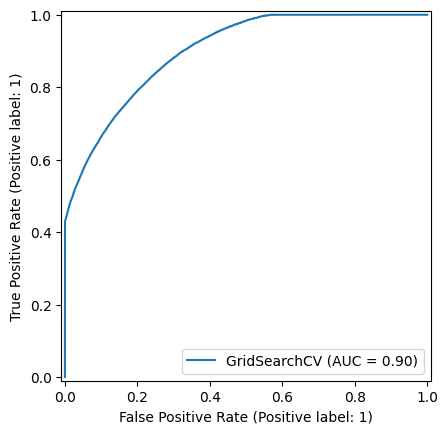

In [103]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    grid_sgdlogreg_minmax, X_test_minmax, y_test_minmax, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully-Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(grid_sgdlogreg_minmax, X_test_minmax, y_test_minmax)